## Create Initial states

In [1]:
import numpy as np
from pathlib import Path
import os
import pandas as pd
import torch

import matplotlib.pyplot as plt
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping

from src.models.normal import NormalDegradationModel as NModel, NormalDegradationNLL as NLoss
from src.pipelines.init_states import PlotNormalDistWithData,BestModelTracker
from src.helpers.seed import set_global_seed

In [2]:
data_name = "DS03"
SEED = 42

set_global_seed(SEED)
device = "cpu" # cpu is faster for small models/datasets
experiment_dir = Path('experiments')/data_name
states_dir = experiment_dir/'states'
os.makedirs(states_dir, exist_ok=True)

## Import training data


In [3]:
hi_df = pd.read_csv(experiment_dir/'hidata_dev.csv')
units = hi_df['unit'].astype(int).unique().tolist()
units 

[1, 2, 3, 4, 5, 6, 7, 8, 9]

### Extract degradation onset

In [4]:
onsets = {unit: hi_df[(hi_df['unit']==unit) & (hi_df['hs']==0)]['cycle'].values[0] for unit in units}
del hi_df['hs']

In [5]:
perform_names = [col for col in hi_df.columns if col not in ['unit','cycle']]

performs = {name: 
    {unit: hi_df[hi_df['unit']==unit][name].values for unit in units} 
    for name in perform_names
}
time = {unit: hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Model initialization

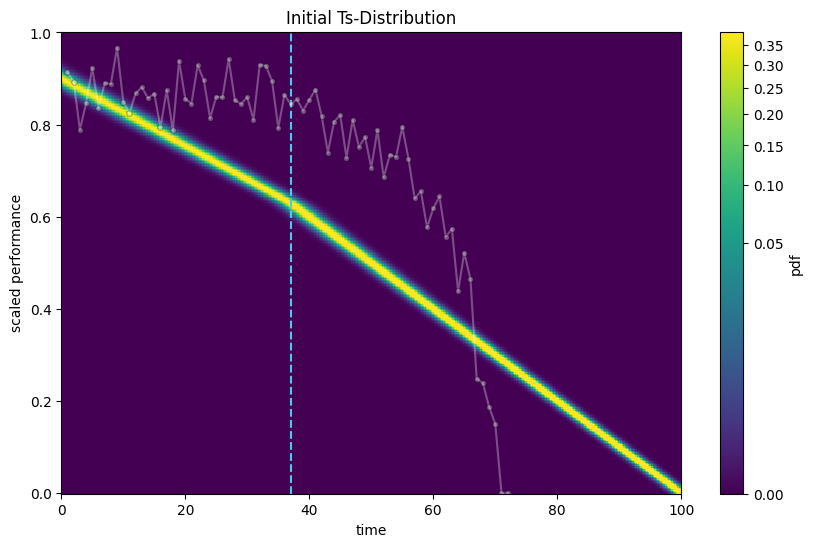

In [6]:
s_np:np.ndarray = performs['SmLPC'][1]
t_np:np.ndarray = time[1]
onset = onsets[1] 

# grids
t = np.linspace(0.1, 100, 400)  # Start from 0.1 instead of 0.0 (LogNormal support is t > 0)
s = np.linspace(0.0, 1.0, 300)

model = NModel(onset=onset)

ax = model.plot_distribution(
    t=t,
    s=s,
    func="pdf",
    title="Initial Ts-Distribution",
)

ax.plot(t_np,s_np,'o-',
		color='white',alpha=0.3,markersize=4,markeredgecolor='black',markeredgewidth=0.8,
  		label='data')
plt.show()

## Create Initial Particles (Training)
The number of (pure) particles $N$ is the the number of training trajectories.

## Callbacks

In [7]:
early_stop_cb = EarlyStopping(
	monitor="train_loss",
	patience=500,
	threshold=1e-5,
	threshold_mode="rel",
	lower_is_better=True,
)

besttracker_cb=BestModelTracker(
	monitor  = "train_loss",
	min_delta = 0.01,
	save_dir = ".", # to be set later
	f_params = "best_model.pt",
	load_best = True,  
)

plot_cb = PlotNormalDistWithData(
	t_grid=t,
	s_grid=s,
	time_data=None,   # to be set later           
	perform_data=None, # to be set later          
	plot_every=None, #
	func="pdf",
	title=None,
	plot_at_end = True,
	show=False, #
	save_dir= None,   # to be set later             
)
    

## Regressor

In [8]:
net = NeuralNetRegressor(
            module=NModel,
            module__onset=None,  # to be set later
            criterion=NLoss,
            optimizer=torch.optim.Adam,
            lr=1e-2,
            max_epochs=100_000, #
            batch_size=-1,
            train_split=None,
            device=device,
            verbose=0,
            callbacks=[besttracker_cb,early_stop_cb, plot_cb],
        )

## Train

In [ ]:
for perform_name, units_perform in performs.items():
    print(f"\nTraining performance: {perform_name}")
    for unit, perform in units_perform.items():
        print(f"  Unit {unit}/{len(units_perform)}", end=" ", flush=True)

		# Prepare data for training 
        t_np: np.ndarray = time[unit]
        s_np: np.ndarray = perform

        X = s_np.astype(np.float32).reshape(-1, 1)
        y = t_np.astype(np.float32).reshape(-1, 1)
        
        # update callbacks with unit-specific info
        unit_dir = states_dir / perform_name / f"unit_{unit}"
        besttracker_cb.save_dir = unit_dir
        plot_cb.save_dir = unit_dir
        plot_cb.title = f"Normal SP for perform {perform_name} Unit {unit}"
        plot_cb.time_data = t_np
        plot_cb.perform_data = s_np
  
        net.set_params(module__onset=onsets[unit])
        net.initialize()
        net.fit(X, y)

        print("Done")

print("initial states training completed.")


Training performance: T48
  Unit 1/9 Done
  Unit 2/9 Done
  Unit 3/9 Done
  Unit 4/9 Done
  Unit 5/9 Done
  Unit 6/9 Done
  Unit 7/9 Done
  Unit 8/9 Done
  Unit 9/9 Done

Training performance: SmLPC
  Unit 1/9 Done
  Unit 2/9 

In [ ]:
NModel.get_state_names()

['m0_raw', 'm1_raw', 'mp_raw', 'v0_raw', 'v1_raw', 'mn_raw', 'vn_raw']